### 我们之前已经把睡眠数据进行整理了，下面对数据进行分析，我们的目标就是得到
### $$P(\text{sleep} | \text{time})$$
### 即，对于睡眠状态对于时间的后验分布

首先加载需要用到的package

In [1]:
# pandas和numpy用来做数据整理和分析
import numpy as np
import pandas as pd

# 利用scipy进行统计计算
import scipy
from scipy import stats

# 利用pymc包来进行贝叶斯推断
import pymc3 as pm
from scipy import optimize

# mathplotlib 用于数据可视化
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

%matplotlib inline
# 由于 %matplotlib inline 的存在，当输入plt.plot(x,y_1)后，不必再输入 plt.show()，图像将自动显示
# 调整图片大小
matplotlib.rcParams['figure.figsize'] = (16, 8)
# 调整字体大小
matplotlib.rcParams['font.size'] = 14
# 调整y轴字体大小
matplotlib.rcParams['ytick.major.size'] = 20
plt.style.use('ggplot')

# Markov chain Monte Carlo 抽样的数量
N_SAMPLES = 5000

D:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


导入数据

In [26]:
sleep_data = pd.read_csv('Desktop/sleep data/sleep_frame.csv')
wake_data = pd.read_csv('Desktop/sleep data/awake_frame.csv')
#做一个labels，后面画图会用到
sleep_labels = ['9:00','9:30','10:00','10:30','11:00','11:30','12:00']
wake_labels = ['5:00','5:30','6:00','6:30','7:00','7:30','8:00']

### 入睡时间

In [3]:
print("number of sleep observations {}".format(len(sleep_data)))

number of sleep observations 11340


我们一共有11340个数据点

In [4]:
sleep_data.head(2)

,Unnamed: 0,indicator,Time_offset
0,2017-12-01 21:00:00,0,-60
1,2017-12-01 21:01:00,0,-59


对于这11340个数据点，我们一共只有两列指标，indicator表示入睡状态，Time_offset代表和22:00的距离

Text(0.5,1,'Falling Asleep Data')

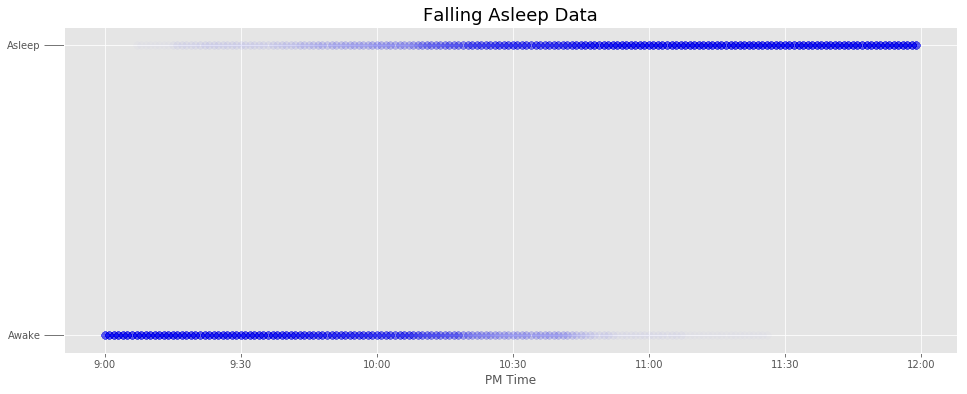

In [5]:
#图片大小
figsize(16,6)
#做XY散点图,x坐标为Time_offset,y坐标为indicator，alpha 是透明度，通过修改透明度，可以使集中的点的颜色更深
plt.scatter(sleep_data['Time_offset'],sleep_data['indicator'],s=60,alpha=0.01,facecolor='b',edgecolors='b')
plt.yticks([0,1],['Awake','Asleep'])                                     #y坐标的大小和标签
plt.xlabel('PM Time')                                                    #x坐标的名字，同样可以对y坐标添加plt.ylabel('State')
plt.xticks([-60,-30,0,30,60,90,120],sleep_labels)                        #x坐标的取值大小和标签
plt.title("Falling Asleep Data",size=18)

### 起床时间
对wake_data 如法炮制便可

In [6]:
?plt.plot()

Text(0.5,1,'Wake Up Data')

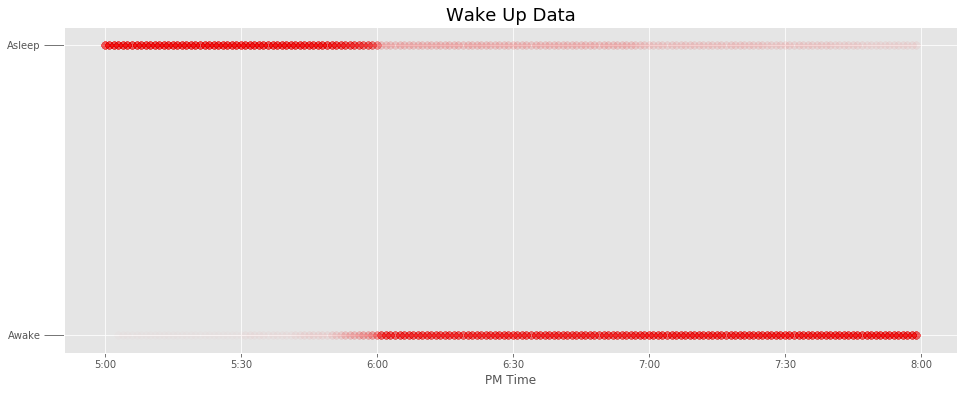

In [7]:
figsize(16,6)
plt.scatter(wake_data['Time_offset'],wake_data['indicator'],s = 60, alpha = 0.01, facecolor = 'r', edgecolor='r')
plt.yticks([0,1],['Awake','Asleep'])
plt.xticks([-60,-30,0,30,60,90,120],wake_labels)
plt.xlabel("PM Time")
plt.title("Wake Up Data",size = 18)

### logistic 函数来表示Awake和Asleep之间的转变
 我们需要一种一个函数来表示我们从awake到asleep之间的转变。在千千万万个模型中，我们假定我们的数据能用logistic函数来表示。 logistic函数是一个从0到1之间取值的非线性函数，也称为S形曲线。生态学中表述物种增长的常用模型就是logistic方程了。当${t \to -\infty}, {P(s|t) \to 0}$ ，而当
 ${t \to +\infty}, {P(s|t) \to 1}$ 。 在我们的例子中，状态（Asleep，Awake）相对于时间的条件概率分布函数可以表示为
 $$P(sleep|time) = \frac {1}{1 + e^{\;\beta t}} $$
 
 $\beta参数在这里是未知的，但是我们可以用$**Markov Chain Monte Carlo**抽样方法（马尔可夫链蒙特卡洛方法）来推断参数它。
 MCMC方法可以帮我们从先验分布中抽取样本，然后找到能让我们概率 $$P(\beta|data)$$ 最大的那个参数

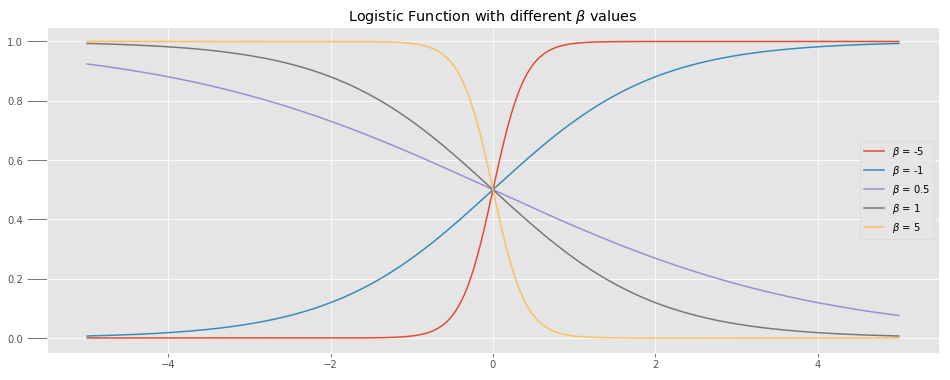

In [23]:
figsize(16,6)
#先定义一个函数
def logistic(x,beta):
    return 1. / (1. + np.exp(beta * x))
# x为从-5到5，间隔为0.01的连续数值
x = np.linspace(-5,5,1000)
#取不同的beta试试
for i in [-5,-1,0.5,1,5]:
    plt.plot(x,logistic(x,i),label=r'$\beta$ = {}'.format(i))                   #必须在string前面添加一个r才能让$\转译生效·
plt.title(r"Logistic Function with different $\beta$ values")
plt.legend()

好了，我们看到非常漂亮的S形曲线，然而我们真正要运用它却还存在一点点小问题。在我们的数据中，转变的过程处于22点和6点左右，这两个时间点并不是在x轴的中间的，而图中的函数变化区间却是集中在0附近的。其实我们只需要对 $x$ 进行一下改动，变成 $x+c$ 就行了，这里的$c是一个常数$*（constant）*。反映在logistic方程中就是
$$P(sleep | time) = \frac{1}{1 + e^{\;\beta (t + c)}} = \frac{1}{e^{\;\beta t + a }} ,  a = \beta * c $$

Text(0,0.5,'Probability')

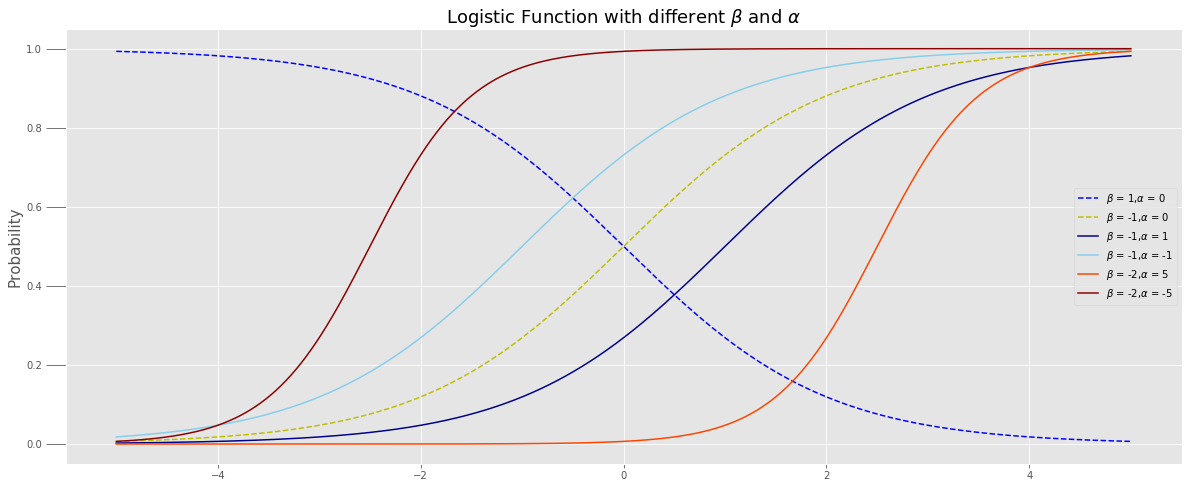

In [31]:
#下面我们来看看不同的a 对logistic函数的影响
figsize(20,8)
#修改一下logistic方程的定义
def logistic(x,beta,alpha=0):
    return 1. / (1. + np.exp(beta*x + alpha))

#参数集
beta_set = [1,-1,-1,-1,-2,-2]
a_set = [0,0,1,-1,5,-5]
color_set = ['b','y','darkblue','skyblue','orangered','darkred']
ls_set = ['--','--','-','-','-','-']

for i in range(6):
    plt.plot(x,logistic(x,beta_set[i],a_set[i]),color=color_set[i]
             ,ls=ls_set[i],label = r'$\beta$ = {},$\alpha$ = {}'.format(beta_set[i],a_set[i]))
plt.legend()
plt.title(r"Logistic Function with different $\beta$ and $\alpha$",size = 18)
plt.ylabel("Probability",size =  15)

我们看到logistic方程的中心在$\beta < 0 ，\alpha > 0 $的时候向左移动。  
在整个logistic方程中，$\beta$ 决定了曲线的方向和斜率，而 $\alpha$ 则影响了曲线的位置

###   $ \beta$ 和 $\alpha$  的先验分布
   由于我们对$ \beta$ 和 $\alpha$没有任何了解，因此我们是没有先验信息的。而且我们采用的后验分布类型是logistic函数近似，所以不考虑共轭分布的beta分布~~说实话，这个我也搞不懂啊，摔书~~。在这种情况下，我们采用正态分布来模拟 $ \beta$ 和 $\alpha$ 的先验分布。正态密度函数形如：
   $$f(x|\mu,\tau) = \sqrt{\frac{\tau}{2 \pi}} e^{{- \frac{\tau}{2}}(x-\mu)^2 }$$  
这里面$\tau$是$\sigma$ 的倒数，一般的形式是 $ N(\mu,\sigma^2)$
   $$f(x|\mu,\sigma) = \frac{1}{\sqrt{2 \pi} \sigma} e^{- \frac{(x-\mu)^2}{2 \sigma ^2}} $$

Text(0,0.5,'Probability Density')

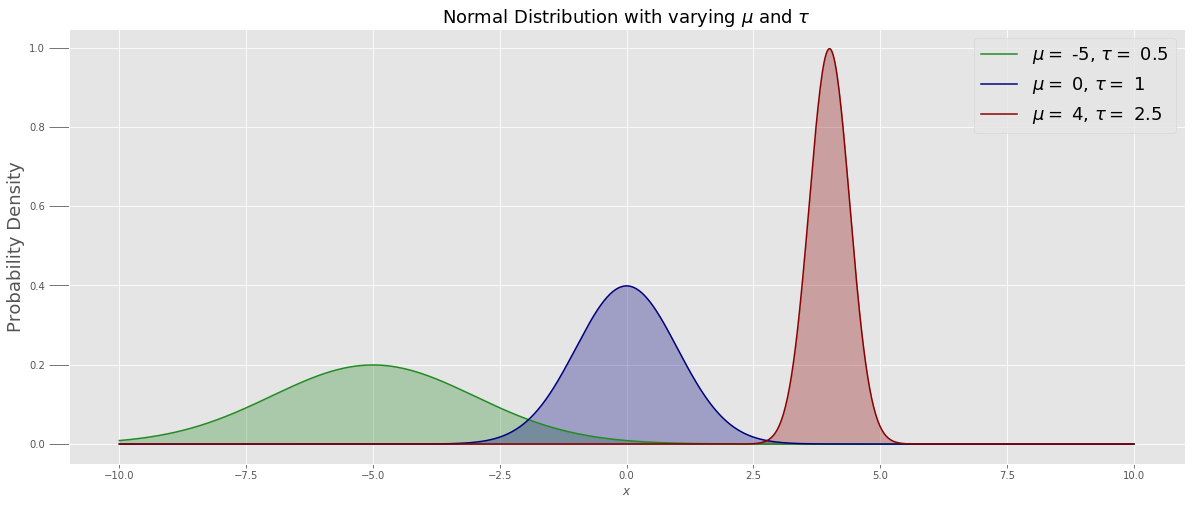

In [10]:
figsize(20,8)
#参数集
x = np.linspace(-10,10,1000)
mu_set = [-5,0,4]
tau_set = [0.5,1,2.5]
color_set = ['forestgreen','navy','darkred']
params = zip(mu_set,tau_set,color_set)

for i in params:
    y = stats.norm.pdf(x,loc=i[0],scale=1/i[1])
    plt.plot(x,y,color=i[2],label=r"$\mu =$ {}, $\tau = $ {}".format(i[0],i[1]) )
    plt.fill_between(x,y,color=i[2],alpha = 0.3)                       #填充
    
plt.legend(prop={"size":18})
plt.title(r"Normal Distribution with varying $\mu$ and $\tau$",size=18)
plt.xlabel("$x$")
plt.ylabel("Probability Density", size = 18)

D:\anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


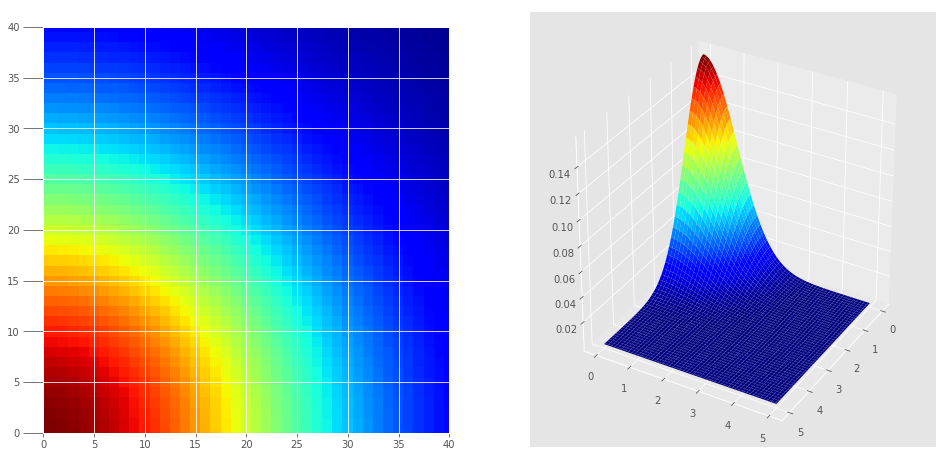

In [11]:
from mpl_toolkits.mplot3d import Axes3D

figsize(16,8)
jet = plt.cm.jet
fig = plt.figure()

x = y = np.linspace(0,5,100)
X,Y = np.meshgrid(x,y)

norm_x = stats.norm.pdf(x,loc=0,scale=1)
norm_y = stats.norm.pdf(y,loc=0,scale=1)

plt.subplot(121)
#np.dot()为矩阵乘法，这里得到的M是一个100x100的矩阵，m（i，j）是norm_x和norm_y的乘积
M = np.dot(norm_x[:,None],norm_y[None,:])                            
im = plt.imshow(M,interpolation='none',origin='lower',cmap=jet)
plt.xlim(0,40)
plt.ylim(0,40)

plt.subplot(122)
ax = fig.add_subplot(122,projection = '3d')                          #必须为这个subplot注明projection=‘3d'，不然没有plot_surface()函数
ax.plot_surface(X,Y,M,cmap = jet)
ax.view_init(azim=30,elev=30)                                               #azim,elev 为水平旋转和竖直旋转度数

我们抽样的期望值其实就是均值
$$ E(X|\mu,\tau) = \mu$$
正态分布的方差就等于
$$ Var[X|\mu,\tau] = \frac{1}{\tau} $$  
由于我们对$\alpha,\beta$的先验分布没有任何了解，我们只能假定$\mu = 0,\tau = 0.05$(也就是$\sigma = 20$,说实话蛮大的)为初始状态。好在Markov chain 的收敛性质与初始状态无关。**Markov Chain Monte Carlo (MCMC)** 方法会通过对$\mu,\sigma$ 采样来使$\alpha,\beta$的可能性最大。

### Markov Chain Monte Carlo 方法  
MCMC会从$\alpha,\beta$各自的先验正态分布中抽样来寻找最优参数。每次重复（即markov链转移到下一个状态），我们就能得到一对$\alpha,\beta$的推断。如果这一对新的$\alpha,\beta$能增加我们的后验概率$P(Data|\alpha,\beta)$，那么我们就接受这次采样（接受markov链的状态转移），反之则拒绝。Markov Chain 是生成新样本的方法，样本（状态）只与前一个状态有关（也可以说该markov链是一种一阶过程）。 Monte Carlo 代表所运用的抽样方法，就是新生成的样本如何接受。最后MCMC会返回我们N个样本（也就是N个成功转移了的状态），这N个样本也被称为**model trace** （模型轨迹？）。我们可以将trace里的N个样本的均值作为我们$\alpha,\beta$参数的最优值。

当我们进行MCMC采样时，最高到前50%的样本会被舍弃掉，被舍弃掉的也被称为burn in part（烧机？）。这是由于markov链未收敛之前都是处于比较无序的阶段，一般到达一定的循环次数后的样本才被认为是稳定的。而在我们这，由于接受采样的条件是后验概率递增，所以前一部分的样本的概率是不如后部分高的，舍弃掉他们可以使样本均值更可靠。其实存在一些方法来确定markov链是否收敛的，比如对trace里的样本计算自相关，低自相关一般认为是markov过程达到收敛了。我们这里就不对trace里的样本就是否收敛进行严格的审查了。另外，其实还有一些方法可以很巧妙地选择初始值来减少我们到达收敛所需的步骤，比如说Maximum A prosterior estimation。

### 睡眠状态对于时间的后验概率

还记得我们是用的logistic方程来描述我们从Awake到Asleep的转变吗？现在要求得后验密度分布所欠缺的只是参数$\alpha,\beta$,我们的目的就是寻找能使给定数据的概率最大的参数。我们假设这两个参数都来自于均值为$\mu$,精准值为$\tau$的正态分布。

### 伯努利变量

在sleep_data和wake_data中，Awake用0表示，Asleep用1表示，也就是说我们的变量只有两个状态：0和1。这种要么为0要么为1的随机变量就称为伯努利变量。还记得二项分布吗，它又称为伯努利分布，服从它的随机变量就是伯努利变量。在我们的数据中，睡眠的伯努利变量是随时间改变的，而随时间改变的具体的描述就是logistic方程。
$$\text{Sleep Probabiliy , $S_i$}\sim \text{Ber} (\;p(t_i)\;),\;\ i = 1...N $$
$p(t_i)$就是以时间为自变量的logistic方程：
$$P(Sleep|t_i) = Ber(\frac{1}{1 + e^{(\beta x + \alpha)}}) $$
MCMC采样就是为了寻找在我们给定的数据和在先验正态分布下最优的参数$\alpha,\beta$

### Pymc3
Pymc3 是非常强大的python统计推断包，这个包6就6在它的MCMC和其他的推断算法。Pymc3的文档推荐了一本书籍 _'Probabilistic Programming and Bayesian Methods for Hackers'_ by Cameron Davidson-Pilon，它的开放链接为[github](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)。 ~~看是不可能看的，这辈子都不可能看的~~  
下面的代码构建了一个简单的模型来运行MCMC采样，最后给$\alpha,\beta$都采了`N_SAMPLES`个样本。具体的MCMC采样方法是[Metropolis Hasting](http://www.mit.edu/~ilkery/papers/MetropolisHastingsSampling.pdf),这是一个为了提高状态转移接受率而做了一点稍稍改进的一种MCMC方法。我们拿sleep_data来训练我们的模型，这个模型会试着给我们返回给定数据的最优参数$\alpha,\beta$。

In [12]:
#把Time_offset升序排列
sleep_data.sort_values('Time_offset',inplace=True)
#Time_offset为时间
time = np.array(sleep_data.loc[:,'Time_offset'])
#状态的观测值是indicator
sleep_obs = np.array(sleep_data.loc[:,'indicator'])

In [13]:
with pm.Model() as sleep_model:
    #告诉模型alpha和beta的先验分布(也是他们的状态转移函数)
    alpha = pm.Normal('alpha',mu=0,tau=0.01,testval=0.0)
    beta = pm.Normal('beta',mu=0,tau=0.01,testval=0.0)
    
    #我们想要的平稳分布,r$\pi$
    p = pm.Deterministic('p',1./(1.+ np.exp(beta * time + alpha)))
    
    #利用bernouli（）把p转换为贝努利变量
    observed = pm.Bernoulli('obs',p,observed=sleep_obs)
    
    #Maximum A Posterior是用来寻找一个比较好的初始值用的
    #start = pm.find_MAP()
    
    #Metropolis Hasting 采样
    step =pm.Metropolis()
    
    #我们要的后验分布的样本将存储在sleep_trace里
    sleep_trace = pm.sample(N_SAMPLES,step=step,njobs =2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 2 chains: 100%|██████████████████████████| 11000/11000 [00:52<00:00, 210.46draws/s]
The number of effective samples is smaller than 10% for some parameters.


由于我们需要同时抽取两个参数$\alpha,\beta$的样本，因此我们同时延伸了两条markov链（njobs=2）。生成的sleep_trace也将会有是一个N_SAMPLES x 2的`array`。`sleep_trace`包含了$\alpha,\beta$的所有样本，我们试试把它可视化，这样我们就能实际地观察样本值随时间进程的变化情况。我们之前提过，MCMC采用的一个思想是使样本的出现的概率会随着算法的逐渐增加，所以我们认为后面抽取的样本的准确性会高于前面的样本。在MCMC我们常常会把前50%的数据抛弃。在实际运用中，采样的数量会更多，这样抛弃掉前半部分数据后任有足够数量的样本。

### $\alpha$ 和 $\beta$ 样本的可视化
把保存在`sleep_trace`里的 $\alpha$、$\beta$用柱状图的形式展示

In [14]:
#提取样本
alpha_sample = np.array(sleep_trace['alpha'][:,None])
beta_sample = np.array(sleep_trace['beta'][:,None])

Text(0,0.5,'Probability Density')

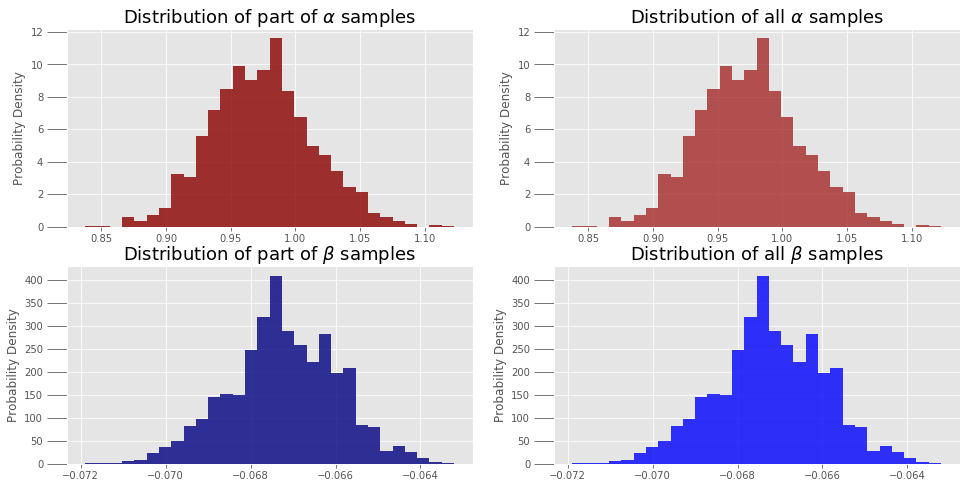

In [15]:
figsize(16,8)
fig = plt.figure()
plt.subplot(221)

###plt.hist()的几个参数，bins柱的数量，alpha透明度，histype:["bar",'barscalar','step','stepfilled'],density把频数转化为概率密度,cumulative：转化为累积分布形式
plt.hist(alpha_sample,bins=30,alpha=0.8,color='darkred',histtype="stepfilled",density=True,cumulative=False)
plt.title(r"Distribution of part of $\alpha$ samples",size=18)
plt.ylabel("Probability Density")

#指向2号subplot
plt.subplot(222)
plt.hist(sleep_trace['alpha'][:,None],bins=30,alpha=0.8,color='brown',histtype="stepfilled",density=True,cumulative=False)
plt.title(r"Distribution of all $\alpha$ samples",size=18)
plt.ylabel("Probability Density")

#另一种指向子图的方式
p3 = fig.add_subplot(223)
p3.hist(beta_sample,bins=30,alpha=0.8,color='navy',histtype='bar',density=True,)
plt.title(r"Distribution of part of $\beta$ samples",size=18)
plt.ylabel("Probability Density")

p4 = fig.add_subplot(224)
p4.hist(sleep_trace['beta'][:,None],bins=30,alpha=0.8,color='blue',histtype='bar',density=True,)
plt.title(r"Distribution of all $\beta$ samples",size=18)
plt.ylabel("Probability Density")

如果$\beta$集中在0附近，那么说明状态和时间的关系不大。样本的分布情况或多或少反映了数据的不确定性，分布的越宽，说明数据的不确定性越大。在这种情况下，我们要想获得最大化后验概率，就取$\beta,\alpha$的均值

###  睡眠状态的后验概率 可视化


In [16]:
#先做一个时间轴
time_est = np.linspace(time.min()-15,time.max()+15,1000)[:,None]

#求均值啦
alpha_est = alpha_sample.mean()
beta_est = beta_sample.mean()

#我们之前就定义好的logistic方程
sleep_est = logistic(time_est,beta_est,alpha_est)

Text(0.5,0,'Time PM')

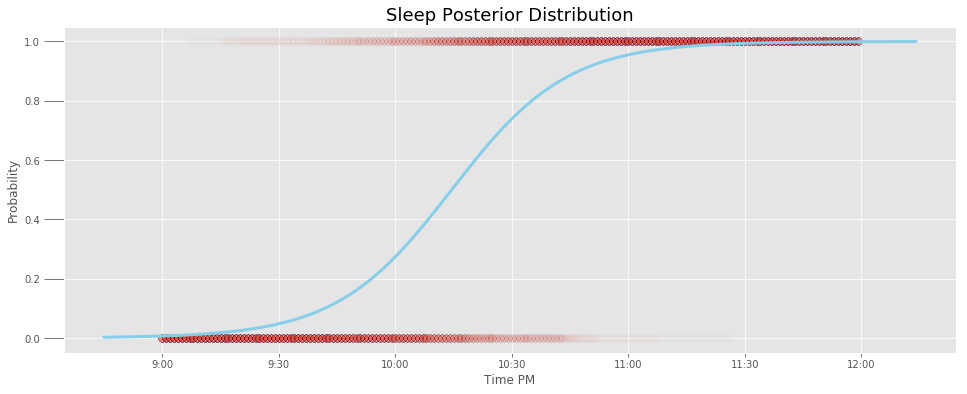

In [17]:
figsize(16,6)

#plot出使用了最优beta和alpha的logistic方程
plt.plot(time_est,sleep_est,ls='-',lw=3,color='skyblue',label='Maximum Likely Prosterior Distribution')

#scatter出我们的实际数据
plt.scatter(sleep_data['Time_offset'][:,None],sleep_data['indicator'][:,None],marker='o',s=60,alpha=0.01,edgecolors='navy',label = 'Observation Data')
plt.title('Sleep Posterior Distribution',size=18)
plt.ylim(-0.05,1.05)
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels)
plt.ylabel('Probability')
plt.xlabel('Time PM')

随着时间逐渐推移，后验概率逐渐从0增加到1。由于数据噪声的干扰，我们的模型不是最完美的（全局最优），但已经是足够好的了

In [18]:
print('the probability of sleep increases above 50% at 10:{} PM'.format(int(time_est[np.min(np.where(sleep_obs >0.5))])))

the probability of sleep increases above 50% at 10:29 PM


  
这里的代码稍微修改了一点，原本的`np.where(sleep_obs >0.5)[0][0]`改为了`np.min(np.where(sleep_obs >0.5))`,下面是原代码  


In [19]:
print('the probability of sleep increases above 50% at 10:{} PM'.format(int(time_est[np.where(sleep_obs >0.5)[0][0]])))

the probability of sleep increases above 50% at 10:29 PM


Text(0.5,1,'Probability of Sleep as Function of Time')

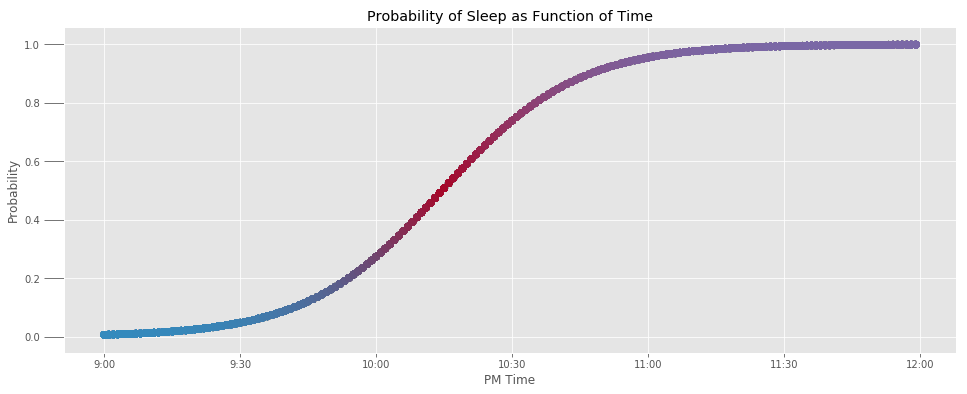

In [20]:
figsize(16,6)

probs = sleep_trace['p']

#三个组成渐变的颜色
colors = ["#348ABD", "#A60628", "#7A68A6"]
#线性渐变的颜色映射
c_map = matplotlib.colors.LinearSegmentedColormap.from_list("BMH", colors)

#注意x是 time， y是probs的在每个时间的均值,c：颜色参数，颜色深浅和变化由概率密度值的大小决定
plt.scatter(time,probs.mean(axis=0),c=probs.mean(axis=0),cmap=c_map,s=50)
plt.xlabel('PM Time')
plt.ylabel('Probability')
plt.xticks([-60,-30,0,30,60,90,120],sleep_labels)
plt.title("Probability of Sleep as Function of Time")

关于`sleep_trace`，其实它有三个参数：alpha，beta，p。我们可以看看它们的维数，这可以帮助我们理解为什么`probs`要用`mean(axis=0)`

In [21]:
#有一个方便的函数
trace_df = pm.trace_to_dataframe(sleep_trace)

In [22]:
np.shape(trace_df.iloc[0,2:])

(11340,)

我们可以看看最开始的样本和最后的样本差距有多大

([<matplotlib.axis.XTick at 0x17efb6c2588>,
 <a list of 7 Text xticklabel objects>)

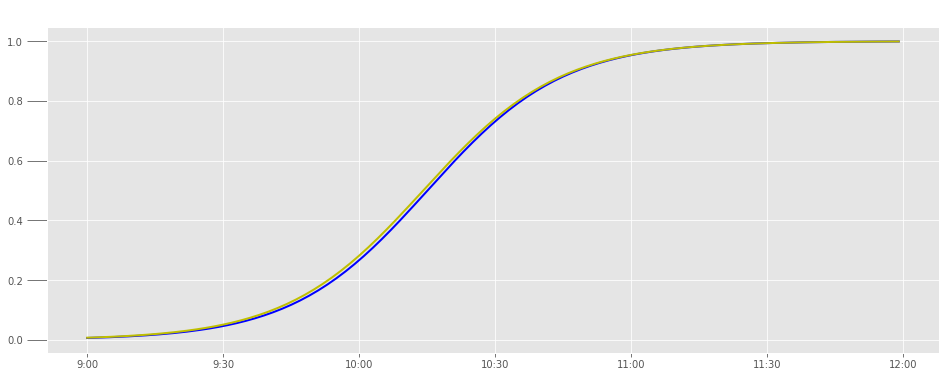

In [23]:
plt.plot(time,logistic(time,trace_df.iloc[0,1],trace_df.iloc[0,0]),color='blue',lw=2)
plt.plot(time,logistic(time,trace_df.iloc[9999,1],trace_df.iloc[9999,0]),color='y',lw=2)
plt.xticks([-60,-30,0,30,60,90,120],sleep_labels)

这样`probs`和 `time` 的维数就一样了

In [24]:
np.shape(time),np.shape(probs.mean(axis=0))

((11340,), (11340,))

`colors`里的元素是色值，参见[色值表](http://www.5tu.cn/colors/yansedaimabiao.html)

有了参数$ \alpha, \beta$的估计值之后，对每个时刻，我们都能求得一个入睡的概率 $P(Sleep| \beta, \alpha)$  
我们只需要输入特定时刻距离10:00PM的`Time_offset`就行了

In [25]:
print('the probability of falling asleep at time 10:50 PM is {:.2f}%'.format(100*logistic(50,beta_est,alpha_est)))
print('the probability of falling asleep at time 10:10 PM is {:.2f}%'.format(100*logistic(10,beta_est,alpha_est)))
print('the probability of falling asleep at time 10:00 PM is {:.2f}%'.format(100*logistic(0,beta_est,alpha_est)))
print('the probability of falling asleep at time 9:30 PM is {:.2f}%'.format(100*logistic(-30,beta_est,alpha_est)))

the probability of falling asleep at time 10:50 PM is 91.58%
the probability of falling asleep at time 10:10 PM is 42.51%
the probability of falling asleep at time 10:00 PM is 27.40%
the probability of falling asleep at time 9:30 PM is 4.78%


### 入睡概率的置信区间
我们还可以从很多其他的方面对模型进行评估，比如说，我们知道我们对$\beta,\alpha$的估计是存在一定的不确定性的。为了能从图标中反映这种不确定性，我们在绘图时加入95%置信区间

In [26]:
sleep_all_est = logistic(time_est.T,beta_sample,alpha_sample)
np.shape(sleep_all_est)

(10000, 1000)

我们的`beta_sample`和`alpha_sample` 包含了 7500 对 $\beta, \alpha$ 的样本，之前我们回归用的是这7500对样本的均值`beta_est`,`alpha_est`,对每一对参数集，我们都拟合一次logistic方程

In [27]:
quantiles = stats.mstats.mquantiles(sleep_all_est,[0.025,0.975],axis=0)
type(quantiles)

numpy.ma.core.MaskedArray

In [28]:
np.shape(time_est.T[0])

(1000,)

In [29]:
np.shape(quantiles)

(2, 1000)

Text(0,0.5,'Probability')

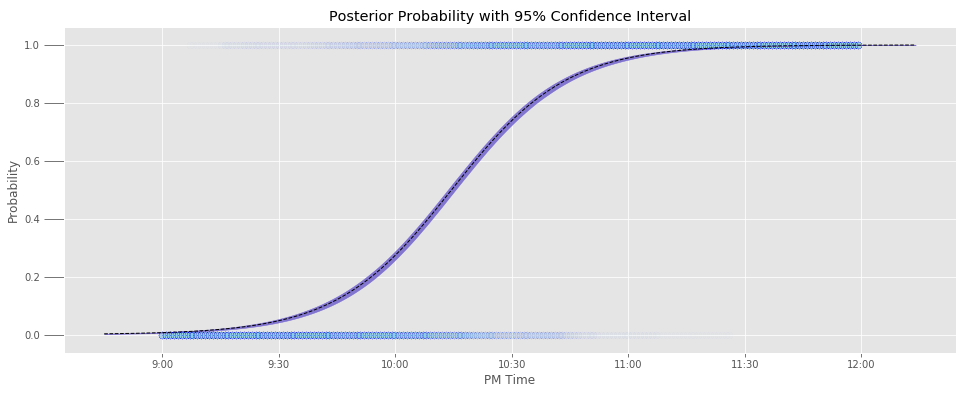

In [30]:
#plot出置信区间
plt.fill_between(time_est.T[0],*quantiles,alpha=0.8,color='slateblue',label='95%CI')

plt.plot(time_est,logistic(time_est,beta_est,alpha_est),color='black',lw=1,ls='--')

plt.scatter(time,sleep_obs,edgecolors='blue',facecolors='skyblue',alpha=0.01,s=50,marker='o')
#plot标题，坐标轴
plt.xticks([-60,-30,0,30,60,90,120],sleep_labels)
plt.title('Posterior Probability with 95% Confidence Interval')
plt.xlabel('PM Time')
plt.ylabel('Probability')

### 每个时间点对应的概率分布

我们的`beta_sample`和`alpha_sample`有许多个样本，这个样本的数量是由抽样的

In [31]:
def posterior_at_time(time_offset,time):
    probs_dstb = logistic(time_offset,beta_sample,alpha_sample)
    plt.hist(probs_dstb,density=False,histtype='step',color='blue',lw=3,bins=30)
    plt.title('Posterior Probability at Time {}'.format(time))
    plt.ylabel('Density')
    plt.xlabel('Probabality')

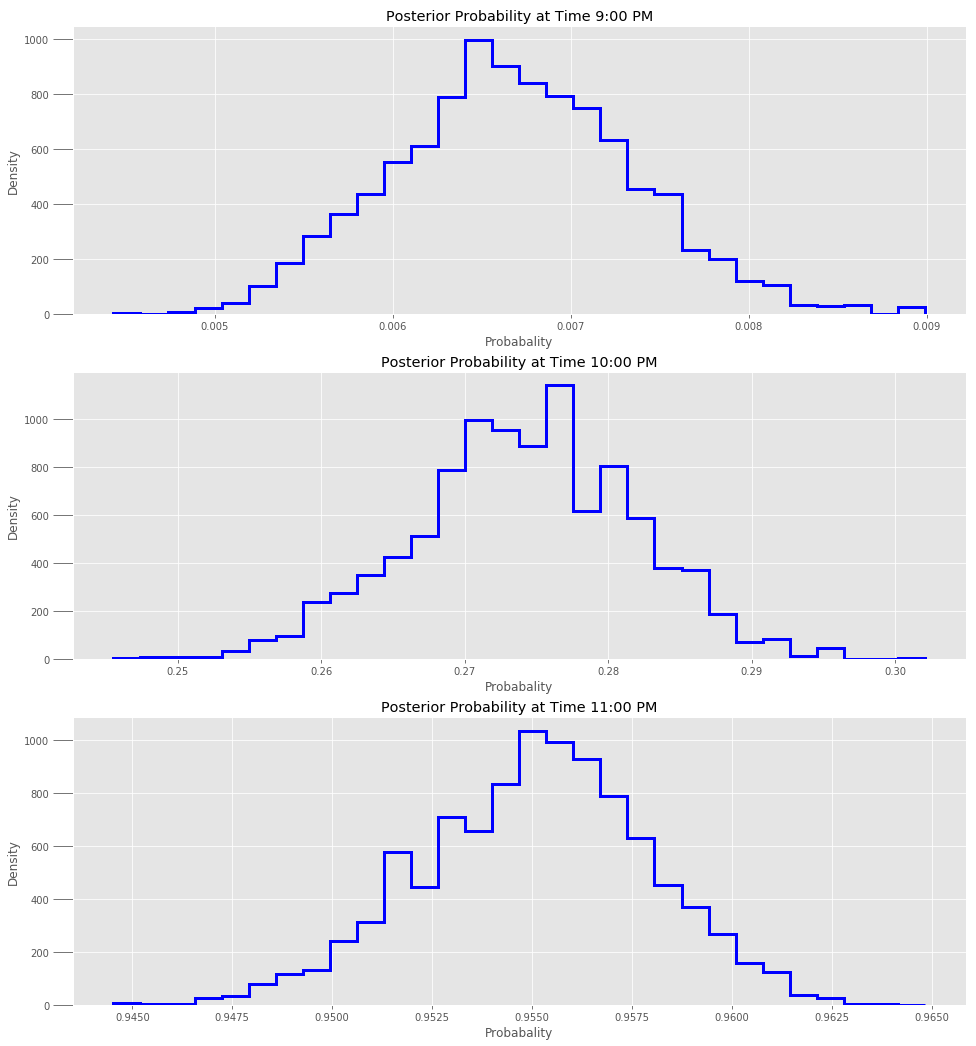

In [32]:
figsize(16,18)
plt.subplot(312)
posterior_at_time(0,"10:00 PM")
plt.subplot(311)
posterior_at_time(-60,"9:00 PM")
plt.subplot(313)
posterior_at_time(60,"11:00 PM")

### Markov Chain Monte Carlo的收敛
上文有提及，Markov链最后会收敛到比较稳定的状态，那么我们怎么知道它收敛了没有。我们可以直接看我们的`sleep_trace`看后面的值是否在几个稳定的取值范围内波动；亦或者查看样本间的自相关系数。

### Trace Plot

Text(0,0.5,'Parameter')

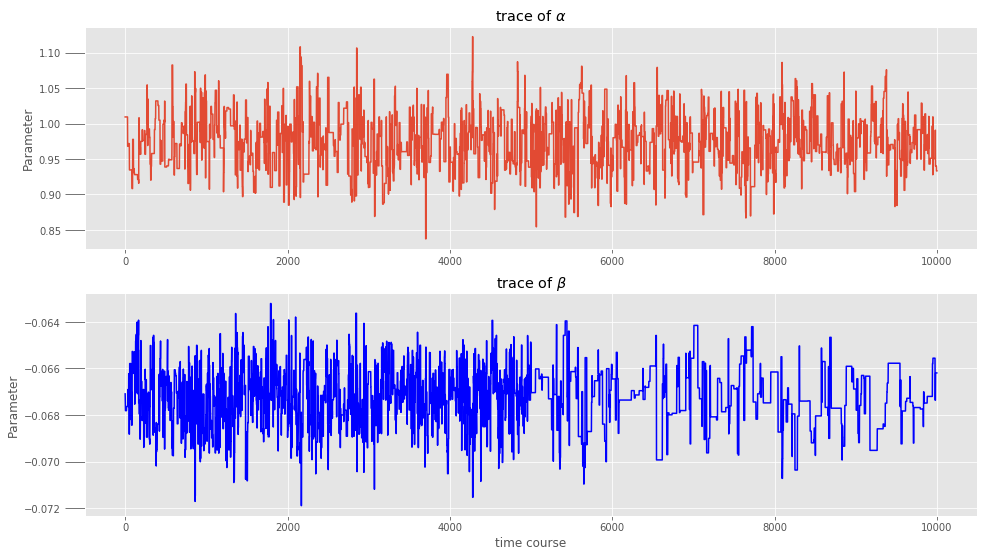

In [33]:
figsize(16,9)
plt.subplot(211)
plt.plot(np.arange(0,10000,1),alpha_sample)
plt.title(r'trace of $\alpha$')

plt.ylabel('Parameter')
plt.subplot(212)
plt.plot(np.arange(0,10000,1),beta_sample,color='b')
plt.title(r'trace of $\beta$')
plt.xlabel('time course')
plt.ylabel('Parameter')

### Pymc3 内置的模型诊断


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017EFB2A8C88>,
      dtype=object)

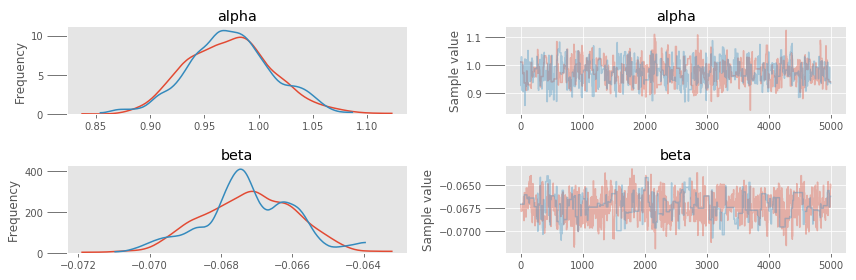

In [34]:
figsize(20,12)
pm.traceplot(sleep_trace,['alpha','beta'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017EFB399320>,
      dtype=object)

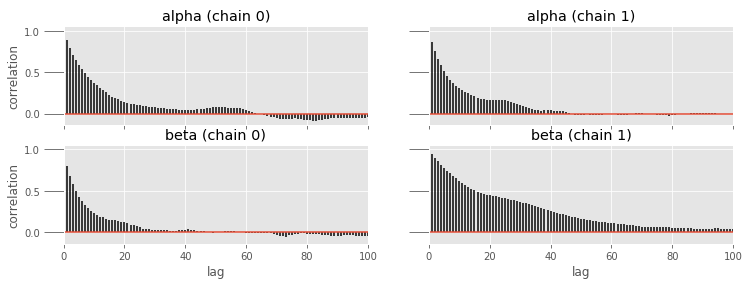

In [35]:
pm.autocorrplot(sleep_trace,['alpha','beta'])

### Wake Model
对wake_frame.csv如法炮制即可

In [41]:
wake_data = pd.read_csv('wake_data.csv')
wake_data.sort_values('time_offset',inplace = True)

time = np.array(wake_data.loc[:,'time_offset'])
wake_obs = np.array(wake_data.loc[:,'indicator'])

In [51]:
with pm.Model() as wake_model:
    alpha = pm.Normal('alpha',mu=0,tau=0.01,testval=0.0)
    beta = pm.Normal('beta',mu=0,tau=0.01,testval=0.0)
    
    p = pm.Deterministic('p',1. /( 1. + np.exp(beta * time + alpha)))
    
    observed = pm.Bernoulli('obs',p,observed = wake_obs)
    
    step = pm.Metropolis()
    
    wake_trace = pm.sample(N_SAMPLES,step = step,njobs=2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 2 chains: 100%|██████████████████████████| 11000/11000 [00:48<00:00, 226.91draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [52]:
alpha_sample = np.array(wake_trace['alpha'][5000:])
beta_sample = np.array(wake_trace['beta'][5000:])
alpha_est = alpha_sample.mean()
beta_est = beta_sample.mean()

Text(0.5,0,'PM time')

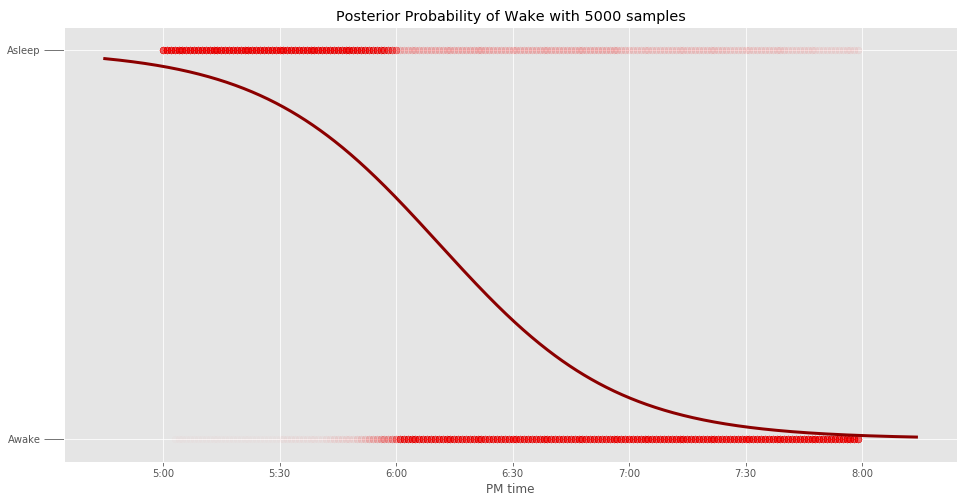

In [57]:
figsize(16,8)

plt.scatter(time,obs,color='red',alpha=0.01,s=50)
time_est = np.linspace(time.min()-15,time.max()+15,1000)
plt.plot(time_est,logistic(time_est,beta_est,alpha_est),lw=3,ls='-',color='darkred')
plt.xticks([-60,-30,0,30,60,90,120],wake_labels)
plt.yticks([0,1],["Awake","Asleep"])
plt.title('Posterior Probability of Wake with 5000 samples')
plt.xlabel('PM time')

展示一下`trace`里的`p`

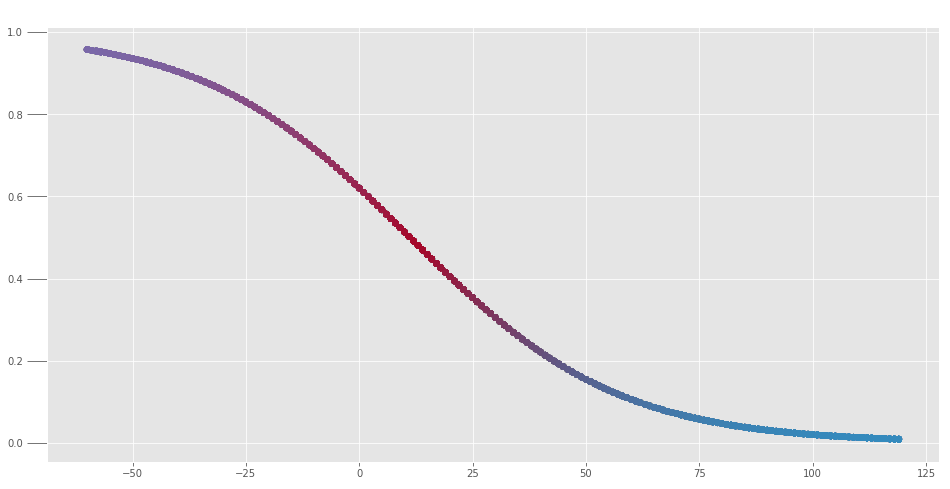

In [68]:
colors = ["#348ABD", "#A60628", "#7A68A8"]
probs = wake_trace['p']
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('BMH',colors) #from list
plt.scatter(time,probs.mean(axis=0),cmap=cmap,c=probs.mean(axis=0))


注意`axis=0`

In [78]:
print(np.shape(wake_trace['p']))
print(np.shape(wake_trace['p'].mean(axis=0)))
print(np.shape(wake_trace['p'].mean(axis=1)))

(10000, 11340)
(11340,)
(10000,)


In [77]:
df_wk = pm.trace_to_dataframe(wake_trace)
df_wk

,alpha,beta,p__0,p__1,p__2,p__3,p__4,p__5,p__6,p__7,...,p__11330,p__11331,p__11332,p__11333,p__11334,p__11335,p__11336,p__11337,p__11338,p__11339
0,-0.519247,0.044010,0.959296,0.959296,0.959296,0.959296,0.959296,0.959296,0.959296,0.959296,...,0.008854,0.008854,0.008854,0.008854,0.008854,0.008854,0.008854,0.008854,0.008854,0.008854
1,-0.519247,0.044010,0.959296,0.959296,0.959296,0.959296,0.959296,0.959296,0.959296,0.959296,...,0.008854,0.008854,0.008854,0.008854,0.008854,0.008854,0.008854,0.008854,0.008854,0.008854
2,-0.519247,0.044010,0.959296,0.959296,0.959296,0.959296,0.959296,0.959296,0.959296,0.959296,...,0.008854,0.008854,0.008854,0.008854,0.008854,0.008854,0.008854,0.008854,0.008854,0.008854
3,-0.519247,0.044010,0.959296,0.959296,0.959296,0.959296,0.959296,0.959296,0.959296,0.959296,...,0.008854,0.008854,0.008854,0.008854,0.008854,0.008854,0.008854,0.008854,0.008854,0.008854
4,-0.477369,0.044010,0.957629,0.957629,0.957629,0.957629,0.957629,0.957629,0.957629,0.957629,...,0.008494,0.008494,0.008494,0.008494,0.008494,0.008494,0.008494,0.008494,0.008494,0.008494
5,-0.477369,0.044010,0.957629,0.957629,0.957629,0.957629,0.957629,0.957629,0.957629,0.957629,...,0.008494,0.008494,0.008494,0.008494,0.008494,0.008494,0.008494,0.008494,0.008494,0.008494
6,-0.477369,0.044010,0.957629,0.957629,0.957629,0.957629,0.957629,0.957629,0.957629,0.957629,...,0.008494,0.008494,0.008494,0.008494,0.008494,0.008494,0.008494,0.008494,0.008494,0.008494
7,-0.510738,0.044010,0.958962,0.958962,0.958962,0.958962,0.958962,0.958962,0.958962,0.958962,...,0.008780,0.008780,0.008780,0.008780,0.008780,0.008780,0.008780,0.008780,0.008780,0.008780
8,-0.510738,0.044010,0.958962,0.958962,0.958962,0.958962,0.958962,0.958962,0.958962,0.958962,...,0.008780,0.008780,0.008780,0.008780,0.008780,0.008780,0.008780,0.008780,0.008780,0.008780
9,-0.510738,0.044010,0.958962,0.958962,0.958962,0.958962,0.958962,0.958962,0.958962,0.958962,...,0.008780,0.008780,0.008780,0.008780,0.008780,0.008780,0.008780,0.008780,0.008780,0.008780


### 睡眠时长的模型
根据我们的原始数据，我们还可以根据入睡时间和苏醒时间计算入睡时长并建立模型

In [240]:
raw_data = pd.read_csv('sleep_wake.csv')
sleep_length = 8. - (raw_data['Sleep']/60) + (raw_data['Wake']/60)

Text(0.5,1,'length of sleep')

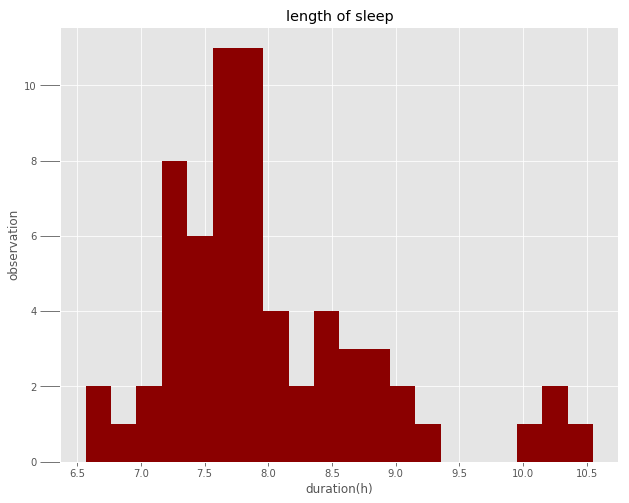

In [241]:
figsize(10,8)
plt.hist(sleep_length,bins=20,histtype='bar',color="darkred")
plt.xlabel('duration(h)')
plt.ylabel('observation')
plt.title('length of sleep')

In [ ]:
因为这个分布是右偏的，所以我们用一个偏倚正太分布来描述它

D:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'length of sleep')

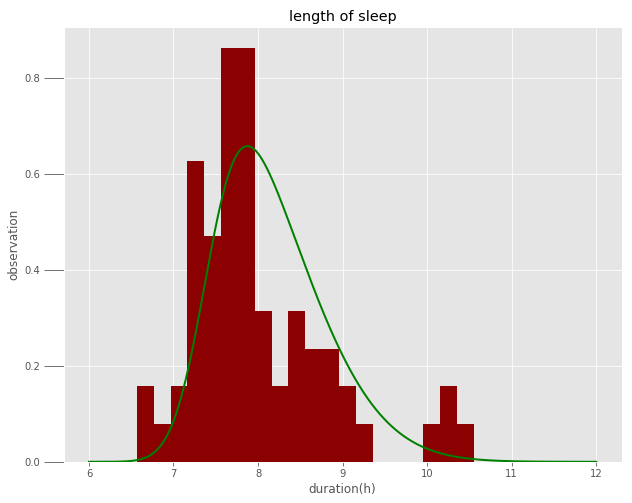

In [268]:

x = np.linspace(6,12,1000)
figsize(10,8)
plt.plot(x,stats.skewnorm.pdf(x,3,loc = 7.4,scale=1),color='green',lw=2)
plt.hist(sleep_length,color = 'darkred',bins = 20,normed=True)
plt.xlabel('duration(h)')
plt.ylabel('observation')
plt.title('length of sleep')



### 睡眠时间模型
skewnromal 里有三个参数是未知的$\alpha,\mu,\sigma$,我们同样使用MCMC来估计参数

In [244]:
with pm.Model() as duration_model:
    alpha_skw = pm.Normal('a',mu=0,tau = 0.5, testval = 3)
    mu_skw = pm.Normal('mu',mu=0,tau = 0.5, testval = 8)
    tau_skw = pm.Normal('tau',mu=0,tau=0.5,testval = 1)
    
    duration = pm.SkewNormal('duration',alpha = alpha_skw,mu = mu_skw, sd=1/tau_skw, observed = sleep_length)
    
    step = pm.Metropolis()

    duration_trace = pm.sample(N_SAMPLES,njobs=2,step = step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [mu]
>Metropolis: [a]
Sampling 2 chains: 100%|█████████████████████████| 11000/11000 [00:07<00:00, 1536.03draws/s]
The number of effective samples is smaller than 10% for some parameters.


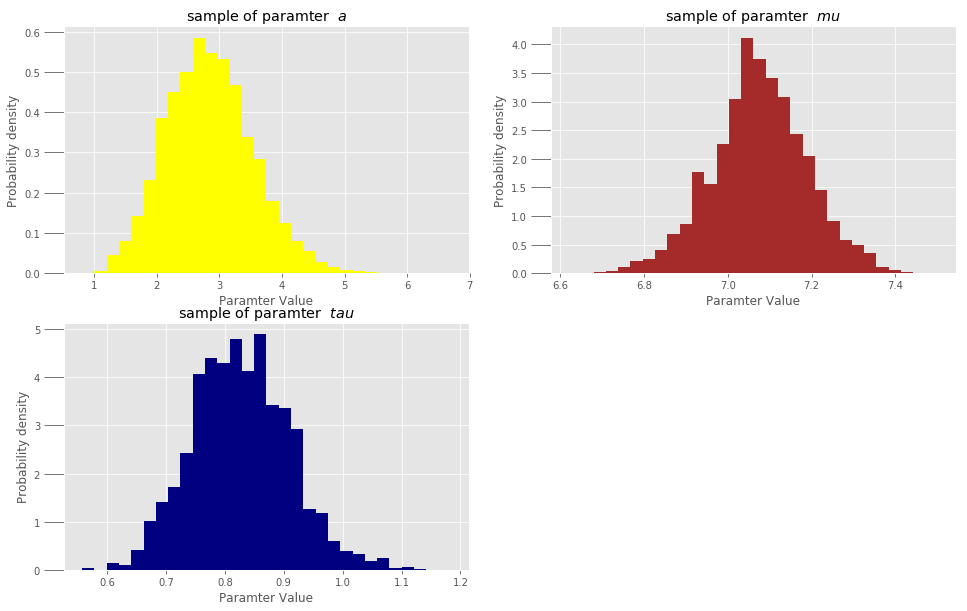

In [245]:
def hist_dura_trace(Param,color):
    plt.hist(duration_trace[Param],bins=30,density=True,color = color ,histtype='stepfilled')
    plt.title(r'sample of paramter $\ '+ Param + r'$')
    plt.xlabel('Paramter Value')
    plt.ylabel('Probability density')

figsize(16,10)
plt.subplot(221)
hist_dura_trace('a','yellow')
plt.subplot(222)
hist_dura_trace('mu','brown')
plt.subplot(223)
hist_dura_trace('tau','navy')

老样子，我们只要后50%的样本，并且用均值作为估计值

In [246]:
a_sample = duration_trace['a'][5000:,]
mu_sample = duration_trace['mu'][5000:,]
tau_sample = duration_trace['tau'][5000:,]
a_est = a_sample.mean()
mu_est = mu_sample.mean()
tau_est = tau_sample.mean()

试试看估计的参数如何

Text(0.5,1,'SkewNormal Distribution with Estimated Parameter $\\alpha,\\mu,\\tau$')

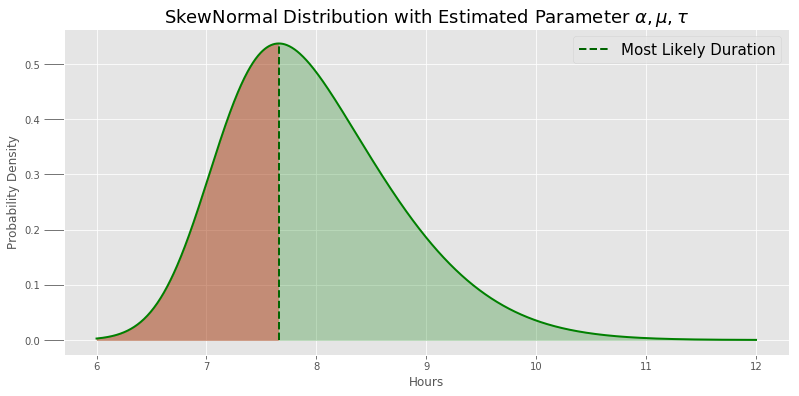

In [250]:
figsize(13,6)
x = np.linspace(6,12,1000)
y = stats.skewnorm.pdf(x,a_est,loc=mu_est,scale= 1/tau_est)
line_v = np.argmax(y)
plt.plot(x,y,color='green',lw=2)
plt.fill_between(x,y,color='forestgreen',alpha=0.3)
plt.fill_between(x[:line_v],y[:line_v],color='red',alpha=0.3)
plt.vlines(x=x[np.argmax(y)],ymin=0,ymax=y.max(),linestyles='--',lw=2,color = 'darkgreen',label='Most Likely Duration')
plt.xlabel('Hours')
plt.ylabel("Probability Density")
plt.legend(prop={"size":15})
plt.title(r"SkewNormal Distribution with Estimated Parameter $\alpha,\mu,\tau$",size=18)

### 询问特定睡眠时长的概率  
注意我们要用概率分布函数`cdf()` 来回答这个问题

In [251]:
print("the probability of sleep for more than 6.5 hour is {:.2f}%"
      .format(100*(1-stats.skewnorm.cdf(6.5,a_est,loc=mu_est,scale= 1/tau_est))))
print("the probability of sleep for more than 7.5 hour is {:.2f}%"
      .format(100*(1-stats.skewnorm.cdf(7.5,a_est,loc=mu_est,scale= 1/tau_est))))
print("the probability of sleep for more than 8.5 hour is {:.2f}%"
      .format(100*(1-stats.skewnorm.cdf(8.5,a_est,loc=mu_est,scale= 1/tau_est))))
print("the probability of sleep for 6 to 9 hour is {:.2f}%"
      .format(100*(stats.skewnorm.cdf(9,a_est,loc=mu_est,scale= 1/tau_est)-stats.skewnorm.cdf(6,a_est,loc=mu_est,scale= 1/tau_est))))
print("the probability of less than 9 hour is {:.2f}%"
      .format(100*(stats.skewnorm.cdf(9,a_est,loc=mu_est,scale= 1/tau_est))))

the probability of sleep for more than 6.5 hour is 99.04%
the probability of sleep for more than 7.5 hour is 70.39%
the probability of sleep for more than 8.5 hour is 23.80%
the probability of sleep for 6 to 9 hour is 88.87%
the probability of less than 9 hour is 88.90%


D:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Durantion Model')

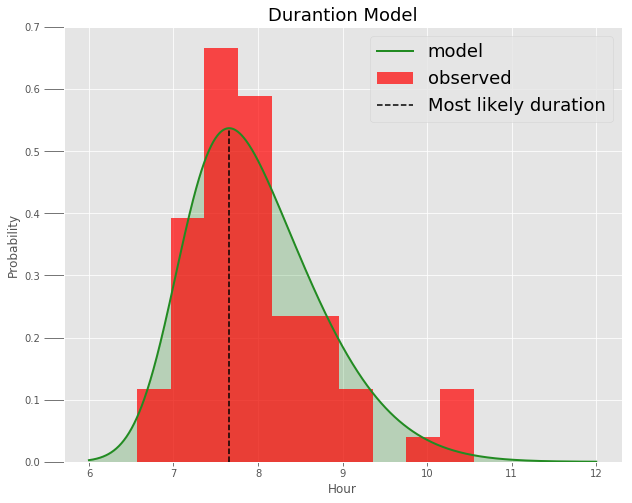

In [263]:
figsize(10,8)
plt.hist(sleep_length,bins=10,color='red',label='observed',normed=True,alpha=0.7)
plt.plot(x,y,color='forestgreen',lw=2,label='model')
plt.fill_between(x,y,color='green',alpha=0.2)
plt.vlines(x[np.argmax(y)],ymin=0,ymax=y.max(),linestyles='--',colors='black',label='Most likely duration')
plt.legend(prop={'size':18})
plt.xlabel('Hour')
plt.ylabel('Probability')
plt.title('Durantion Model',size=18)

偏倚正态分布模型看起来大致上很贴近数据，然而如果我们观测数据再画的详细一些

D:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Durantion Model')

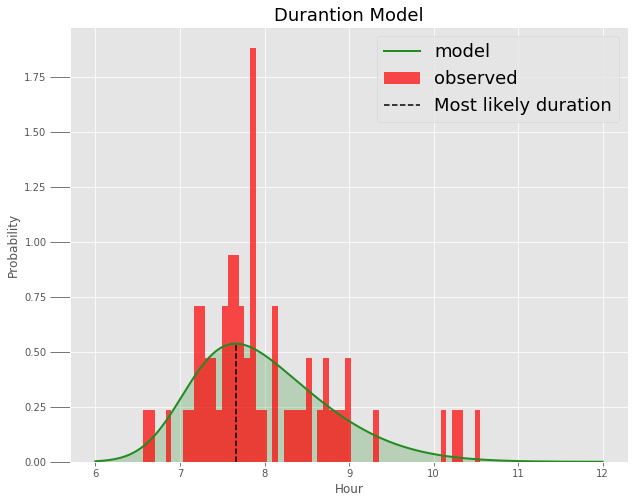

In [266]:
figsize(10,8)
plt.hist(sleep_length,bins=60,color='red',label='observed',normed=True,alpha=0.7)
plt.plot(x,y,color='forestgreen',lw=2,label='model')
plt.fill_between(x,y,color='green',alpha=0.2)
plt.vlines(x[np.argmax(y)],ymin=0,ymax=y.max(),linestyles='--',colors='black',label='Most likely duration')
plt.legend(prop={'size':18})
plt.xlabel('Hour')
plt.ylabel('Probability')
plt.title('Durantion Model',size=18)

我们就发现实际上右侧并不能很好地被我们的模型覆盖，因此，把数据的右侧部分用另一个模型来拟合可能会更好

虽然有些瑕疵，但是我们用MCMC建出来的模型还是能解释总体的睡眠规律，本篇到此结束！！